In [1]:
# =========================================
# 📦 1. INSTALL & IMPORT LIBRARIES
# =========================================
!pip install pandas matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# =========================================
# 📂 2. UPLOAD FILES TO COLAB
# =========================================
from google.colab import files

print("Please upload the 3 CSV files:")
uploaded = files.upload()

# Expected file names:
# - incompatibility_rules_cleaned.csv
# - sku_level_cleaned.csv
# - optimal_allocations (1).csv

Please upload the 3 CSV files:


Saving incompatibility_rules_cleaned.csv to incompatibility_rules_cleaned.csv
Saving sku_level_cleaned.csv to sku_level_cleaned.csv
Saving optimal_allocations (1).csv to optimal_allocations (1).csv


In [3]:
# =========================================
# 📥 3. LOAD DATA
# =========================================
allocations_df = pd.read_csv("optimal_allocations (1).csv")
sku_df = pd.read_csv("sku_level_cleaned.csv")
rules_df = pd.read_csv("incompatibility_rules_cleaned.csv")

print("Allocations file preview:")
display(allocations_df.head())

print("\nSKU-level file preview:")
display(sku_df.head())

print("\nIncompatibility rules file preview:")
display(rules_df.head())

Allocations file preview:


,sku,zone_id,volume_m3,priority,near_loading_dock,distance
0,ITM0000,ZONE-H,0.027048,0.0,True,1
1,ITM0001,ZONE-H,0.171720,0.0,True,1
2,ITM0002,ZONE-A,0.129960,0.0,False,10
3,ITM0003,ZONE-G,0.031119,0.0,False,10
4,ITM0004,ZONE-B,0.264810,20.0,True,1



SKU-level file preview:


,item_id,category,weight_kg,length_cm,width_cm,height_cm,stackable,fragile,hazardous,temperature_range,current_on_hand_qty,volume_m3_per_unit,movement_count,total_units_moved,last_movement,on_hand_units,total_on_hand_volume_m3
0,ITM0000,Home Goods,25.51,28,69,14,True,False,True,Ambient,112,0.027048,0.0,0.0,NaN,112,3.029376
1,ITM0001,Beverages,41.41,45,72,53,True,True,True,Ambient,445,0.171720,0.0,0.0,NaN,445,76.415400
2,ITM0002,Frozen Foods,16.34,38,95,36,False,True,False,Frozen,358,0.129960,0.0,0.0,NaN,358,46.525680
3,ITM0003,Beverages,44.83,69,11,41,True,False,False,Frozen,280,0.031119,0.0,0.0,NaN,280,8.713320
4,ITM0004,Beverages,19.77,91,97,30,False,True,True,Frozen,116,0.264810,1.0,20.0,2025-07-24,116,30.717960



Incompatibility rules file preview:


,category_1,category_2
0,Electronics,Flammable
1,Batteries,Chemicals
2,Batteries,Flammable
3,Chemicals,Electronics
4,Chemicals,Flammable


In [5]:
# =========================================
# 🔍 4. IDENTIFY KEY COLUMNS
# =========================================
# Auto-detect likely column names
possible_sku_cols = [c for c in allocations_df.columns if 'sku' in c.lower()]
possible_zone_cols = [c for c in allocations_df.columns if 'zone' in c.lower()]
possible_qty_cols = [c for c in allocations_df.columns if 'qty' in c.lower() or 'quantity' in c.lower()]

sku_col = possible_sku_cols[0]
zone_col = possible_zone_cols[0]

# Check if possible_qty_cols is not empty before accessing the first element
if possible_qty_cols:
  qty_col = possible_qty_cols[0]
else:
  qty_col = None # Or handle the case where no quantity column is found

print(f"Detected columns → SKU: {sku_col}, Zone: {zone_col}, Quantity: {qty_col}")

Detected columns → SKU: sku, Zone: zone_id, Quantity: None


In [7]:
# =========================================
# 🏗 5. BASELINE CAPACITY & DEMAND
# =========================================
# Sum allocations to get current zone capacities
baseline_zone_capacity = allocations_df.groupby(zone_col)['volume_m3'].sum().to_dict()

# Sum allocations to get current SKU demand
baseline_sku_demand = allocations_df.groupby(sku_col)['volume_m3'].sum().to_dict()

print("Baseline Zone Capacity:", baseline_zone_capacity)
print("\nBaseline SKU Demand:", list(baseline_sku_demand.items())[:10], "...")

Baseline Zone Capacity: {'ZONE-A': 4.454328, 'ZONE-B': 8.401356, 'ZONE-C': 7.379332, 'ZONE-D': 9.540426, 'ZONE-E': 0.282115, 'ZONE-G': 5.655418, 'ZONE-H': 26.256887, 'ZONE-I': 2.310246, 'ZONE-J': 9.632871999999999}

Baseline SKU Demand: [('ITM0000', 0.027048), ('ITM0001', 0.17172), ('ITM0002', 0.12996), ('ITM0003', 0.031119), ('ITM0004', 0.26481), ('ITM0005', 0.015147), ('ITM0006', 0.0162), ('ITM0007', 0.241192), ('ITM0008', 0.509808), ('ITM0009', 0.13833)] ...


In [8]:
# =========================================
# 🔄 6. CREATE SENSITIVITY SCENARIOS
# =========================================
capacity_factors = [0.8, 0.9, 1.0, 1.1, 1.2]  # 80% to 120% capacity
demand_factors = [0.8, 1.0, 1.2]              # 80%, 100%, 120% demand

scenarios = []
for cap in capacity_factors:
    for dem in demand_factors:
        scenarios.append({
            "scenario": f"C{int(cap*100)}_D{int(dem*100)}",
            "capacity_factor": cap,
            "demand_factor": dem
        })

scenarios_df = pd.DataFrame(scenarios)
scenarios_df

,scenario,capacity_factor,demand_factor
0,C80_D80,0.8,0.8
1,C80_D100,0.8,1.0
2,C80_D120,0.8,1.2
3,C90_D80,0.9,0.8
4,C90_D100,0.9,1.0
5,C90_D120,0.9,1.2
6,C100_D80,1.0,0.8
7,C100_D100,1.0,1.0
8,C100_D120,1.0,1.2
9,C110_D80,1.1,0.8


In [10]:
# =========================================
# 📊 7. APPLY SCALING TO ALLOCATIONS
# =========================================
all_scenario_allocations = []

for _, row in scenarios_df.iterrows():
    scenario_name = row["scenario"]
    cap_factor = row["capacity_factor"]
    dem_factor = row["demand_factor"]

    # Scale zone capacities
    scenario_zone_capacity = {z: c * cap_factor for z, c in baseline_zone_capacity.items()}
    # Scale SKU demand
    scenario_sku_demand = {s: d * dem_factor for s, d in baseline_sku_demand.items()}

    # Start from baseline allocation & scale by both factors
    scaled_allocations = allocations_df.copy()
    scaled_allocations['volume_m3'] = scaled_allocations.apply(
        lambda x: min(
            x['volume_m3'] * dem_factor,  # demand scaling
            scenario_zone_capacity[x[zone_col]] *
            (x['volume_m3'] / baseline_zone_capacity[x[zone_col]])  # capacity scaling within zone
        ),
        axis=1
    )

    scaled_allocations["scenario"] = scenario_name
    all_scenario_allocations.append(scaled_allocations)

# Combine all scenarios
allocations_sensitivity_df = pd.concat(all_scenario_allocations, ignore_index=True)
allocations_sensitivity_df

,sku,zone_id,volume_m3,priority,near_loading_dock,distance,scenario
0,ITM0000,ZONE-H,0.021638,0.0,True,1,C80_D80
1,ITM0001,ZONE-H,0.137376,0.0,True,1,C80_D80
2,ITM0002,ZONE-A,0.103968,0.0,False,10,C80_D80
3,ITM0003,ZONE-G,0.024895,0.0,False,10,C80_D80
4,ITM0004,ZONE-B,0.211848,20.0,True,1,C80_D80
...,...,...,...,...,...,...,...
7495,ITM0495,ZONE-H,0.059717,0.0,True,1,C120_D120
7496,ITM0496,ZONE-H,0.543715,0.0,True,1,C120_D120
7497,ITM0497,ZONE-E,0.026827,0.0,False,10,C120_D120
7498,ITM0498,ZONE-H,0.061420,73.0,True,1,C120_D120


In [12]:
# =========================================
# 📈 8. CALCULATE KPIs
# =========================================
kpi_results = []

for scenario_name, group in allocations_sensitivity_df.groupby("scenario"):
    total_served = group['volume_m3'].sum()
    total_demand = sum(baseline_sku_demand.values()) * \
                   float(scenarios_df.loc[scenarios_df.scenario == scenario_name, "demand_factor"])
    unmet_demand = max(0, total_demand - total_served)

    avg_utilization = group.groupby(zone_col)['volume_m3'].sum().mean() / \
                      np.mean(list(baseline_zone_capacity.values())) * 100

    kpi_results.append({
        "scenario": scenario_name,
        "total_demand": total_demand,
        "served": total_served,
        "unmet_demand": unmet_demand,
        "avg_zone_utilization_%": avg_utilization
    })

kpis_df = pd.DataFrame(kpi_results)
kpis_df

/tmp/ipython-input-3482089831.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(scenarios_df.loc[scenarios_df.scenario == scenario_name, "demand_factor"])
/tmp/ipython-input-3482089831.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(scenarios_df.loc[scenarios_df.scenario == scenario_name, "demand_factor"])
/tmp/ipython-input-3482089831.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(scenarios_df.loc[scenarios_df.scenario == scenario_name, "demand_factor"])
/tmp/ipython-input-3482089831.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(scenarios_df.loc[scenarios_

,scenario,total_demand,served,unmet_demand,avg_zone_utilization_%
0,C100_D100,73.912980,73.912980,0.000000,100.0
1,C100_D120,88.695576,73.912980,14.782596,100.0
2,C100_D80,59.130384,59.130384,0.000000,80.0
3,C110_D100,73.912980,73.912980,0.000000,100.0
4,C110_D120,88.695576,81.304278,7.391298,110.0
5,C110_D80,59.130384,59.130384,0.000000,80.0
6,C120_D100,73.912980,73.912980,0.000000,100.0
7,C120_D120,88.695576,88.695576,0.000000,120.0
8,C120_D80,59.130384,59.130384,0.000000,80.0
9,C80_D100,73.912980,59.130384,14.782596,80.0


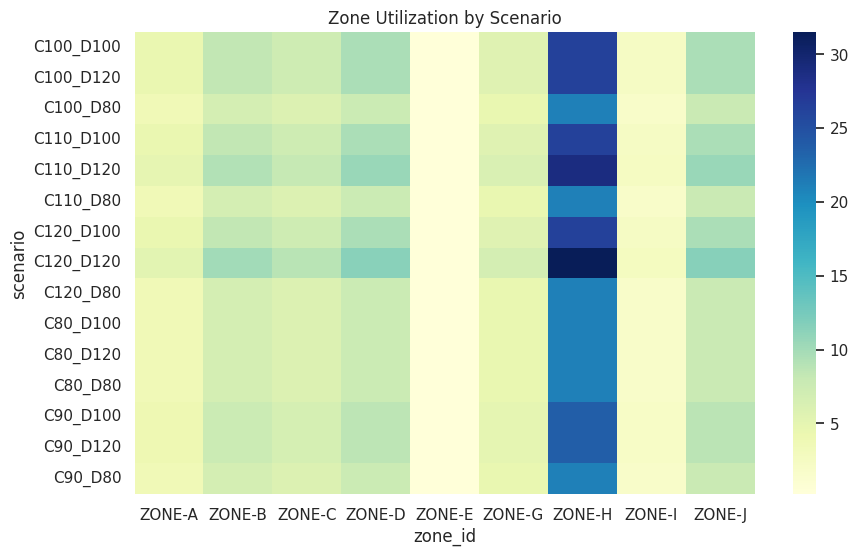

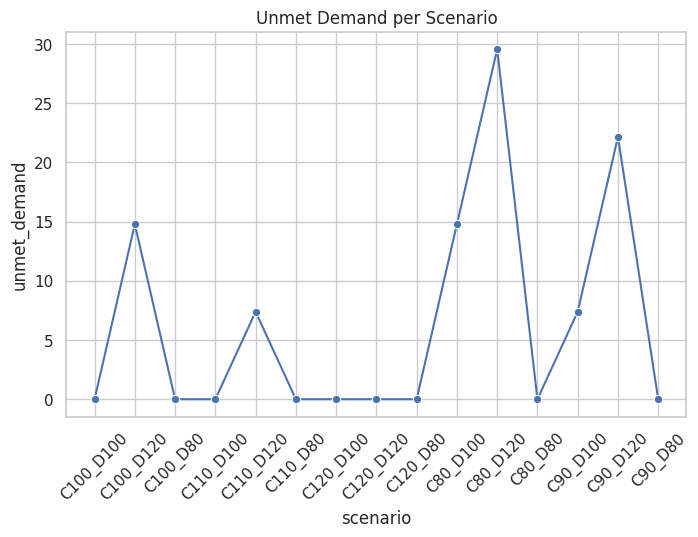

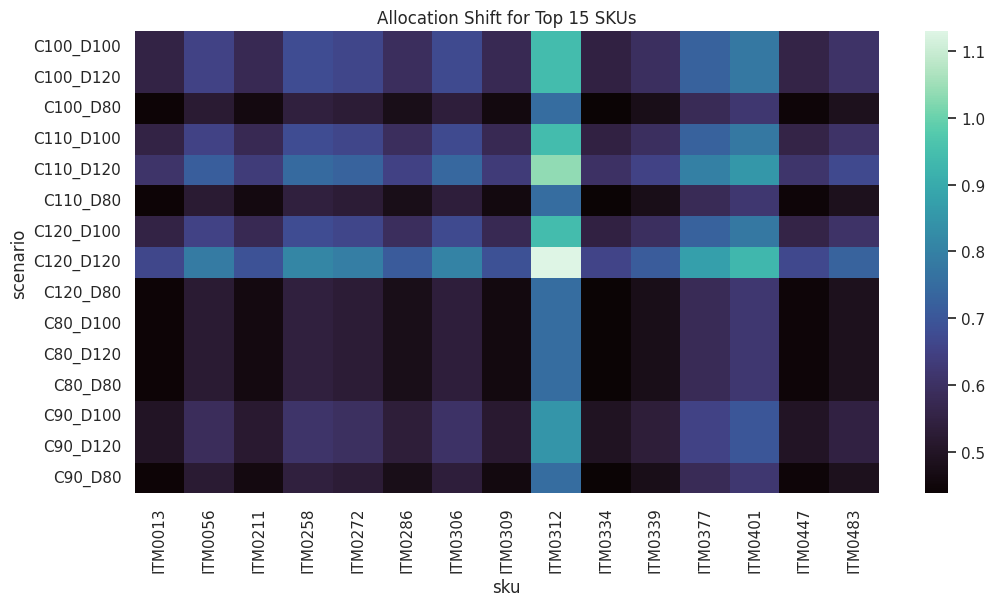

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# =========================================
# 🎨 9. VISUALISATIONS
# =========================================
sns.set(style="whitegrid")

# Zone Utilization Heatmap
zone_util = allocations_sensitivity_df.groupby(["scenario", zone_col])['volume_m3'].sum().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(zone_util, annot=False, cmap="YlGnBu")
plt.title("Zone Utilization by Scenario")
plt.savefig("zone_utilization_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Unmet Demand Line Plot
plt.figure(figsize=(8,5))
sns.lineplot(data=kpis_df, x="scenario", y="unmet_demand", marker="o")
plt.title("Unmet Demand per Scenario")
plt.xticks(rotation=45)
plt.savefig("unmet_demand_lineplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Allocation Shifts Heatmap for Top SKUs
top_skus = allocations_df.groupby(sku_col)['volume_m3'].sum().nlargest(15).index
sku_alloc = allocations_sensitivity_df[allocations_sensitivity_df[sku_col].isin(top_skus)]
sku_shift = sku_alloc.groupby(["scenario", sku_col])['volume_m3'].sum().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(sku_shift, cmap="mako")
plt.title("Allocation Shift for Top 15 SKUs")
plt.savefig("allocation_shifts_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 📥 Optional: Download all saved images
files.download("zone_utilization_heatmap.png")
files.download("unmet_demand_lineplot.png")
files.download("allocation_shifts_heatmap.png")

In [16]:
# =========================================
# 💾 10. EXPORT RESULTS
# =========================================
kpis_df.to_csv("sensitivity_kpis.csv", index=False)
zone_util.to_csv("sensitivity_zone_utilization.csv")
allocations_sensitivity_df.to_csv("sensitivity_allocations.csv", index=False)

print("✅ Files saved: sensitivity_kpis.csv, sensitivity_zone_utilization.csv, sensitivity_allocations.csv")

# Allow download in Colab
files.download("sensitivity_kpis.csv")
files.download("sensitivity_zone_utilization.csv")
files.download("sensitivity_allocations.csv")

✅ Files saved: sensitivity_kpis.csv, sensitivity_zone_utilization.csv, sensitivity_allocations.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>